In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Importing and formatting

The first section of this notebook is dedicated to importing the results and true solutions data from the BPPLIB library (https://site.unibo.it/operations-research/en/research/bpplib-a-bin-packing-problem-library#:~:text=The%20BPPLIB%20is%20a%20collection,Delorme%2C%20M.) and making formatting consistent across the pandas dataframes.

In [10]:
def read_results_df(csv_path, drop_duplicates=True):
    df = pd.read_csv(csv_path)
    if drop_duplicates:
        df = df.drop_duplicates(subset='DataFile')
    return df

def select_random_subsets(df, prefix1_count, prefix2_count):
    # Filter rows based on prefixes
    df_prefix1 = df[df['DataFile'].str.startswith('./BPPLIB/Scholl_CSP_dat/Scholl_1')]
    df_prefix2 = df[df['DataFile'].str.startswith('./BPPLIB/Scholl_CSP_dat/Scholl_2')]

    # Randomly sample rows from each filtered DataFrame
    df_sampled_prefix1 = df_prefix1.sample(n=prefix1_count, random_state=1)
    df_sampled_prefix2 = df_prefix2.sample(n=prefix2_count, random_state=1)

    # Combine the sampled rows into one DataFrame
    return pd.concat([df_sampled_prefix1, df_sampled_prefix2])

def format_true_solutions_df(true_solutions_path):
    df = pd.read_csv(true_solutions_path)
    df.drop(columns=['Best LB', 'Best UB', 'Status'], inplace=True)
    df.rename(columns={'Name': 'DataFile'}, inplace=True)
    df = df[~df['DataFile'].str.startswith('HARD')]
    def transform_datafile_string(value):
        if value[2] == 'C':
            return f"./BPPLIB/Scholl_CSP_dat/Scholl_1/{value.replace('.txt', '.dat')}"
        elif value[2] == 'W':
            return f"./BPPLIB/Scholl_CSP_dat/Scholl_2/{value.replace('.txt', '.dat')}"
        else:
            raise Exception
    df['DataFile'] = df['DataFile'].apply(transform_datafile_string)

    return df

# Keep only those true solutions for problems we have attempted
def drop_unused_problems(results_df, true_solutions_df):
    filtered_true_solutions_df = true_solutions_df[true_solutions_df['DataFile'].isin(results_df['DataFile'])]
    return filtered_true_solutions_df

# A function to merge the two dataframes and make things tidier
def merge_df(results_df, true_solutions_df):
    df = pd.merge(results_df, true_solutions_df, on='DataFile')
    df.rename(columns={'ObjectiveValue': 'ResultObjective', 'Solution': 'OptimalObjective'}, inplace=True)
    return df

In [3]:
scholl_csv = 'scholl-results.csv'
results_df = read_results_df(scholl_csv, drop_duplicates=True)

In [4]:
scholl_1_prefix = './BPPLIB/Scholl_CSP_dat/Scholl_1'
scholl_2_prefix = './BPPLIB/Scholl_CSP_dat/Scholl_2'

print(results_df['DataFile'].str.startswith(scholl_1_prefix).sum())
print(results_df['DataFile'].str.startswith(scholl_2_prefix).sum())

173
55


In [5]:
results_df = select_random_subsets(results_df, 170, 50)
print(results_df['DataFile'].str.startswith(scholl_1_prefix).sum())
print(results_df['DataFile'].str.startswith(scholl_2_prefix).sum())
results_df

170
50


,DataFile,ObjectiveValue
107,./BPPLIB/Scholl_CSP_dat/Scholl_1/N2C2W4_R.dat,57.0
142,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C3W2_B.dat,20.0
19,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C1W4_A.dat,35.0
76,./BPPLIB/Scholl_CSP_dat/Scholl_1/N4C1W2_P.dat,317.0
53,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C2W4_L.dat,31.0
...,...,...
224,./BPPLIB/Scholl_CSP_dat/Scholl_2/N4W1B2R6.dat,217.0
208,./BPPLIB/Scholl_CSP_dat/Scholl_2/N1W2B2R4.dat,17.0
223,./BPPLIB/Scholl_CSP_dat/Scholl_2/N1W1B1R1.dat,19.0
213,./BPPLIB/Scholl_CSP_dat/Scholl_2/N4W2B2R6.dat,118.0


In [8]:
true_solutions_path = './BPPLIB/true-solutions/SCHOLL-SOLUTIONS.csv'
true_solutions_df = format_true_solutions_df(true_solutions_path)
true_solutions_df = drop_unused_problems(results_df, true_solutions_df)
true_solutions_df

,DataFile,Selected,Solution
2,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C1W1_C.dat,1,20.0
8,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C1W1_I.dat,1,25.0
13,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C1W1_N.dat,1,25.0
20,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C1W2_A.dat,1,29.0
29,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C1W2_J.dat,1,34.0
...,...,...,...
1126,./BPPLIB/Scholl_CSP_dat/Scholl_2/N4W2B2R6.dat,1,103.0
1133,./BPPLIB/Scholl_CSP_dat/Scholl_2/N4W2B3R3.dat,1,100.0
1142,./BPPLIB/Scholl_CSP_dat/Scholl_2/N4W3B1R2.dat,1,71.0
1151,./BPPLIB/Scholl_CSP_dat/Scholl_2/N4W3B2R1.dat,1,71.0


In [54]:
merged_df = merge_df(results_df, true_solutions_df)

# Comparison of results and true solutions

Now we move on to comparing our obtained objective values (by solving CSPs' LP relaxations with column generation + an IP solution once no columns price out favourably to enter the solution basis) with the true known optimal solutions (perhaps by proper branch-and-price and other methods).

In [42]:
def compute_errors(merged_df):
    # This will always be positive, since it's a minimisation problem we are dealing with
    merged_df['AbsError'] = merged_df['ResultObjective'] - merged_df['OptimalObjective']
    merged_df['RelError'] = merged_df['AbsError'] / merged_df['OptimalObjective']

def hist_relative_error(merged_df):
    # Plotting the histogram of relative errors
    plt.hist(merged_df['RelError'] * 100, alpha=1)
    plt.title('Histogram of Relative Errors')
    plt.xlabel('Relative Error (%)')
    plt.ylabel('Frequency')
    plt.show()

def hist_absolute_error(merged_df):
    # Plotting the histogram of relative errors
    plt.hist(merged_df['AbsError'], alpha=1)
    plt.title('Histogram of Absolute Errors')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()

In [57]:
compute_errors(merged_df)
merged_df_scholl_1 = merged_df[merged_df['DataFile'].str.contains('Scholl_1')]
merged_df_scholl_2 = merged_df[merged_df['DataFile'].str.contains('Scholl_2')]

In [62]:
merged_df_scholl_1

,DataFile,ResultObjective,Selected,OptimalObjective,AbsError,RelError
0,./BPPLIB/Scholl_CSP_dat/Scholl_1/N2C2W4_R.dat,57.0,1,56.0,1.0,0.017857
1,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C3W2_B.dat,20.0,1,20.0,0.0,0.000000
2,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C1W4_A.dat,35.0,1,35.0,0.0,0.000000
3,./BPPLIB/Scholl_CSP_dat/Scholl_1/N4C1W2_P.dat,317.0,1,317.0,0.0,0.000000
4,./BPPLIB/Scholl_CSP_dat/Scholl_1/N1C2W4_L.dat,31.0,1,31.0,0.0,0.000000
...,...,...,...,...,...,...
165,./BPPLIB/Scholl_CSP_dat/Scholl_1/N2C2W2_L.dat,55.0,1,52.0,3.0,0.057692
166,./BPPLIB/Scholl_CSP_dat/Scholl_1/N4C2W2_N.dat,265.0,1,264.0,1.0,0.003788
167,./BPPLIB/Scholl_CSP_dat/Scholl_1/N4C3W4_F.dat,222.0,1,222.0,0.0,0.000000
168,./BPPLIB/Scholl_CSP_dat/Scholl_1/N2C3W4_S.dat,42.0,1,42.0,0.0,0.000000


In [64]:
merged_df_scholl_2.head()

,DataFile,ResultObjective,Selected,OptimalObjective,AbsError,RelError
170,./BPPLIB/Scholl_CSP_dat/Scholl_2/N2W2B1R4.dat,27.0,1,21.0,6.0,0.285714
171,./BPPLIB/Scholl_CSP_dat/Scholl_2/N2W4B1R9.dat,21.0,1,11.0,10.0,0.909091
172,./BPPLIB/Scholl_CSP_dat/Scholl_2/N3W1B3R4.dat,73.0,1,68.0,5.0,0.073529
173,./BPPLIB/Scholl_CSP_dat/Scholl_2/N3W3B1R2.dat,37.0,1,29.0,8.0,0.275862
174,./BPPLIB/Scholl_CSP_dat/Scholl_2/N2W1B2R0.dat,40.0,1,36.0,4.0,0.111111


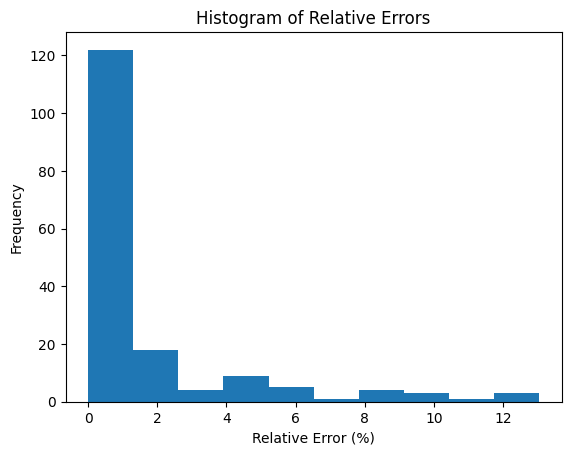

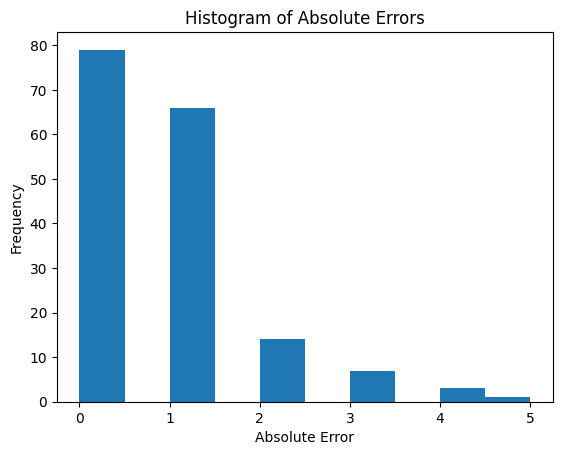

In [60]:
hist_relative_error(merged_df_scholl_1)
hist_absolute_error(merged_df_scholl_1)

In [73]:
# Large portion of these problems were optimally solved!
merged_df_scholl_1[merged_df_scholl_1['AbsError'] == 0.0]['AbsError'].size / merged_df_scholl_1['DataFile'].size * 100

46.470588235294116

In [74]:
# Not so much these though...
merged_df_scholl_2[merged_df_scholl_2['AbsError'] == 0.0]['AbsError'].size / merged_df_scholl_2['DataFile'].size * 100

6.0

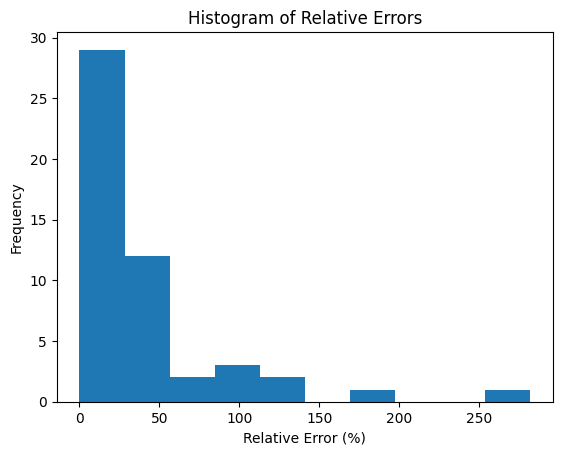

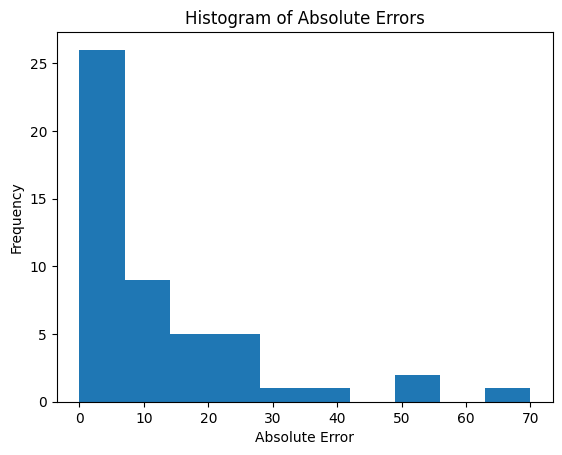

In [61]:
hist_relative_error(merged_df_scholl_2)
hist_absolute_error(merged_df_scholl_2)